# Predicting hotel cancellation
The main goal of this project is to come up with a model that helps to predict if a person will cancel his/her booking. A good model would help to forecast revenue quite precisely and will allow to plan actions to prevent loosing potential earnings.

In [614]:
#imporing packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestRegressor
df = pd.read_csv('hotel_bookings.csv')

## EDA


In [615]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

First of all, let us see how much money hotels presented in the dataset lost because of cancellation. Before I calculate it, I sum up the number of stays in week nights and stays in weekend noghts to calculate the total numder of stays in nights (and correspondingly drop the two variables from the dataframe).

In [617]:
df['days_of_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df.drop(columns = ['stays_in_week_nights', 'stays_in_weekend_nights'], inplace = True)
df['revenue'] = df['days_of_stay']*df['adr']
canceled_resort = df[(df['is_canceled'] == 1) & (df['hotel'] =='Resort Hotel')]['revenue'].sum()/df[df['hotel'] =='Resort Hotel']['revenue'].sum()
canceled_city = df[(df['is_canceled'] == 1) &(df['hotel'] =='City Hotel')]['revenue'].sum()/df[df['hotel'] =='City Hotel']['revenue'].sum()
qty_resort = df[(df['hotel'] =='Resort Hotel')]['is_canceled'].sum()/df[df['hotel'] =='Resort Hotel']['is_canceled'].count()
qty_city = df[(df['hotel'] =='City Hotel')]['is_canceled'].sum()/df[df['hotel'] =='City Hotel']['is_canceled'].count()
print("forgone revenue % in resort hotels: " + str(canceled_resort.round(2)))
print("number of canceled bookings % in resort hotels: " + str(qty_resort.round(2)))
print("forgone revenue % in city hotels: " + str(canceled_city.round(2)))
print("number of canceled bookings % in city hotels: " + str(qty_city.round(2)))

forgone revenue % in resort hotels: 0.33
number of canceled bookings % in resort hotels: 0.28
forgone revenue % in city hotels: 0.43
number of canceled bookings % in city hotels: 0.42


The main finding is that hotels loose between 33% and 44% of potential revenue because of cancelations. Another insight is that people tend to cancel bookings more often in city hotels. Probably, because of higher number of options available. 

Let us explore the customer types. In hospitality industry firms face a tradeoff: leave rooms empty for transient customers or provide rooms to business groups that book rooms in advance. Therefore, it is interesting to know if the cancelation rate varies over the types, and can it be stated that groups are more reliable that transient clients.


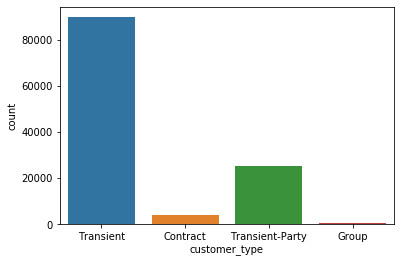

In [618]:
sns.countplot(df['customer_type'])

Another variable that reuests attention is country. Of course, it is possible to create dummy variables, but it is not desirable because of too many countries included. First of all, let us explote if there seem to be any dependency of cancelation rate from country.

It may be supposed that booked room type is related to the cancelation rate. The room type may be a proxy for the income of the customer.

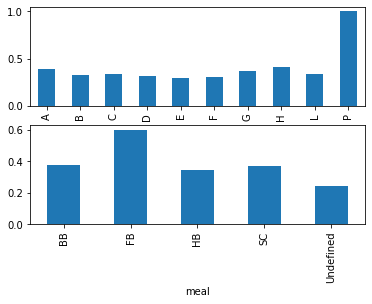

In [619]:
#Share of canceled bookings per room type and meal
room_type = df.groupby('reserved_room_type')['is_canceled'].sum()/df.groupby('reserved_room_type')['is_canceled'].count()
meal = df.groupby('meal')['is_canceled'].sum()/df.groupby('meal')['is_canceled'].count()
plt.subplot(2,1,1)
room_type.plot(kind = 'bar')
plt.subplot(2,1,2)
meal.plot(kind = 'bar')

Apperently, room type does not seem to influence cancelation rate, so the variable is not going to be taken into account. The type 'P' has cancelation rate of 1, but this type was booked only 12 times, so it is not worth exploring. As for meal, hotels proposing full board seem to have higher cancelation rate. 

### Data preprocessing
There is a need to tranform categorical variables to a numerical type. Since there are many categories for some features (for exapmple, countries), conversion to dummy variables will result in creating of high-dimensional space, which may harm work of algorithm. Instead, I am using label encoding method with scikit-learn's LabelEncoder. One drawback of the method is that numerical values may be misinterpreted, for instance, if one uses regression. Since the main purpose is to propose a classifier, this is not the issue.

In [620]:
label = LabelEncoder()
df['country_code'] = label.fit_transform(df['country'].astype('str'))
df['hotel_code'] = label.fit_transform(df['hotel'].astype('str'))
df['arrival_date_month_code'] = label.fit_transform(df['arrival_date_month'].astype('str'))
df['meal_code'] = label.fit_transform(df['meal'].astype('str'))
df['market_segment_code'] = label.fit_transform(df['market_segment'].astype('str'))
df['reserved_room_type_code'] = label.fit_transform(df['reserved_room_type'].astype('str'))
df['deposit_type_code'] = label.fit_transform(df['deposit_type'].astype('str'))
df['customer_type_code'] = label.fit_transform(df['customer_type'].astype('str'))
df['distribution_channel_code'] = label.fit_transform(df['distribution_channel'].astype('str'))


I am creating a new dataframe from the original one with deleted variables that are not relevent, particularly, reservation status and date, because it obviously does not have any causal effect on cancellation rate. Also, I am deleting the column 'company' since it contains mostly null values, so it will have no use, and columns with values transformed to codes. Other variables of concern are month, date and year of arrival that are corelated. It does not really make sense to include year, because the classifier is supposed to make predictions from the future. Between day, week and month I woudl prefer the month, since the it may be supposed that the cancelations may happen during vacations more often.

In [621]:
clean = df.drop(columns = ['arrival_date_month','arrival_date_week_number','arrival_date_year','arrival_date_day_of_month','reservation_status','distribution_channel','assigned_room_type','previous_bookings_not_canceled', 'reservation_status_date', 'company', 'country', 'hotel','meal', 'market_segment', 'reserved_room_type','deposit_type', 'customer_type', 'revenue'])
clean = clean.dropna()



Further, I am checking pairwise relation between variables in order to make sure that I will not face a probem of multicollinearity and get overall picture of how the variables are interrelated. If there is correlation between any two variables and it cannot be safely ignored, I will exclude of the them from the data set. To detect the pairs of correlated varables, I am using the heatmap.

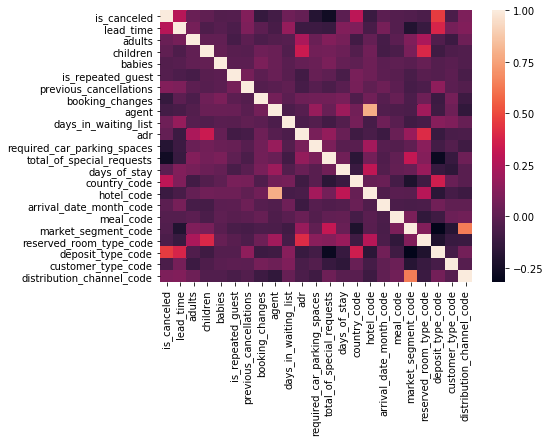

In [622]:
corr = clean.corr()
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(corr)


From the heatmap, it is seen that the distribution channel and maker segment are intercorrelated. The latter variable is at the same time related to deposit tye and number of special requests, so it make sense to drop it to avoid multicollinearity issue. I am dropping the agent as well, since it meems to be related to the hotel type. Resrved room type correlates with adr, which is quite logical, so it does not make sense to keen both variables. I will exclude the type.


In [623]:
clean.drop(columns = ['market_segment_code', 'agent', 'reserved_room_type_code'], inplace = True)

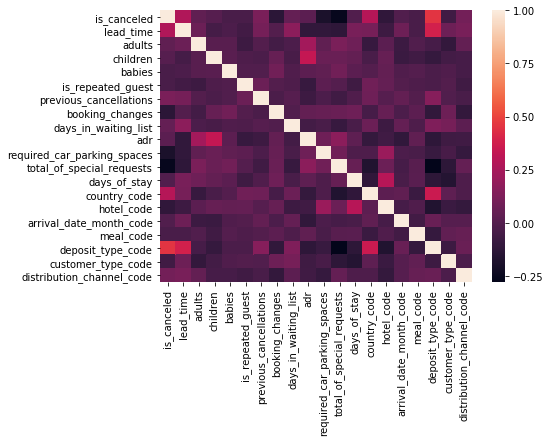

In [624]:
corr = clean.corr()
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr, ax = ax)


From the above dataframe I am extracting the dependent variable and the explanatory ones: y and x.

In [625]:
y = clean['is_canceled']
x = clean.iloc[:, 1:]

The dataset contains a lot of variables, and it is important to exclude the ones that have litle influence on the cancellation rate. For that purpose I am using the Extra Trees Classifier from scikit-learn that will rank the variables by their importance.

In [626]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees = ExtraTreesClassifier()
extra_trees.fit(x, y)
imp = extra_trees.feature_importances_
importance = pd.DataFrame(imp,x.columns)
importance.sort_values(by = [0], ascending = False)



/Users/sofya/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,0
lead_time,0.175690
country_code,0.152545
adr,0.138175
deposit_type_code,0.120045
days_of_stay,0.075356
total_of_special_requests,0.070667
arrival_date_month_code,0.069699
customer_type_code,0.036068
booking_changes,0.025641
previous_cancellations,0.024339


From the result above we can see that deporit type, country, lead time, number of special reuests, arrival dates and duration of stay are the most important variables to predict the cancelation rate. It makes sense to get rid of not important variables, since they may cause overfitting of the classifier. I drop the variables with importance level less than 1%. 

In [627]:
x.drop(columns = ['babies', 'days_in_waiting_list', 'is_repeated_guest', 'distribution_channel_code', 'children'], inplace = True)



Further I am going to implement several classifiers to predict if a booking will be cancelled or not, and select the best one to use.
# Logistic regression


In [628]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3 , random_state = 0)
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print ("Accuracy of logistic regression classifier on the test set is " + "{:.2f}".format(logreg.score(x_test, y_test)))


/Users/sofya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on the test set is 0.76


Now let us take a look at the confusion matrix and classification report to see the precision and recall.


In [629]:
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)

[[17544  1280]
 [ 6008  6083]]


In [630]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.83     18824
           1       0.83      0.50      0.63     12091

    accuracy                           0.76     30915
   macro avg       0.79      0.72      0.73     30915
weighted avg       0.78      0.76      0.75     30915



The precision if the ration of true postive to the total number of positives, which reflects the ability of the model not to classify not cancelled bookings as cancelled. The recall is the ratio of true positives to the sum of true positives and false negatives, which shows the ability of classifier to find all the cancelled bookings.

The classifier manages to distinguish between the cancelled bookings and not cancelled well (83% of precision), but in 50% of cases the cancelled bookings were not identified as cancelled (the recall of 50%).

In [632]:
df['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64